# Описание проблемы

На текущем варианте лендинга пользователь сначала выбирает ритейлера, переходит в каталог, ищет нужные ему товары и только потом может узнать, что по его адресу выбранного магазина может не оказаться. Хотим проверить гипотезу, что выбор адреса до этапа выбора магазина поможет избежать “кривых” сценариев без повышения отказов с самого лендинга.

Описание групп

1 - контрольная (без каких-либо изменений)
2 - тестовая, сначала пользователь указывает адрес, затем выбирает магазин. 

Метрики

Основные метрики, на основе которых будем принимать решение:

- bounce rate лендинга (в тестовых группах он не должен стат значимо вырасти)
- конверсия в добавление в корзину

# Задание

- ❓Проанализируйте дизайн эксперимента. Какие ошибки были допущены? Как можно его улучшить?
- ❓ Проанализируйте данные эксперимента. Какой из вариантов нужно пускать в бой по итогу A/B теста и почему?
- 🕵️ Проведите неофициальное расследование и составьте максимально подробный список аномалий в приведенных данных.

# ----------------------------------------------------------------------------------------------------
# Решение

## Импорт библиотек

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth
import numpy as np

## Ввод данных

In [4]:
ab_test_hit = pd.read_csv('Data\\AB Test Hit.csv')
add_to_cart_clicked = pd.read_csv('Data\\Add To Cart Clicked.csv')
address_change_initiated = pd.read_csv('Data\\Address Change Initiated.csv')
address_not_in_deli = pd.read_csv('Data\\Address Not In Delivery Zone.csv')
landing_viewed = pd.read_csv('Data\\Landing Viewed.csv')
main_viewed = pd.read_csv('Data\\Main Page Viewed.csv')
order_completed = pd.read_csv('Data\\Order Completed.csv')
product_added = pd.read_csv('Data\\Product Added.csv')
shop_selected = pd.read_csv('Data\\Shop Selected.csv')
shop_celection_started = pd.read_csv('Data\\Shop Celection Started.csv')

### Описание и очистка данных

#### DataFrame ab_test_hit - время взита пользователя и назначенная ему группа (A\B)

In [15]:
ab_test_hit.describe()

,hit_at,anonymous_id,group,device_type,browser,os
count,502784,502784,502784,502784,502784,502783
unique,502470,489019,2,5,37,15
top,2020-12-03 05:33:34.021 UTC,5bb785fd-e0e7-447a-b0e1-a06328b31cbe,default,mobile,Chrome,Android
freq,3,18,446474,305530,250245,195489


In [19]:
ab_test_hit.os.value_counts()

Android             195489
Windows             138854
iOS                 118173
Linux                35319
Mac OS               14284
Ubuntu                 517
Chromium OS             50
Windows Phone           35
Fedora                  26
PlayStation             14
Tizen                   13
NetBSD                   4
FreeBSD                  3
Mint                     1
Windows Phone OS         1
Name: os, dtype: int64

Видим пользователей PlayStation, что вряд ли учитывалось в начальном эксперименте. Но поскольку на это ограничений нет, то оставим их

In [20]:
ab_test_hit.device_type.value_counts()

mobile     305530
desktop    190480
tablet       6740
console        18
smarttv        16
Name: device_type, dtype: int64

Та же история и с пользователями, зашедшими со smarttv

Ищем пользователей, попавших в обе группы

In [41]:
dupl_user = ab_test_hit[['anonymous_id','group']].groupby('anonymous_id').nunique().reset_index()
dupl_user[dupl_user['group']>1].shape

(528, 2)

In [48]:
dupl_user=dupl_user[dupl_user['group']>1]

Итого 528 пользователей попавших в обе группы. Это ошибка, которая повлияет на ход эксперимента. Удаляем данных пользователей из эксперимента.

In [51]:
ab_test_hit_clear = ab_test_hit[~ab_test_hit['anonymous_id'].isin(dupl_user['anonymous_id'])]
ab_test_hit_clear.shape

(501626, 6)

Эксперимент проводился с 26 ноября по 10 декабря 2020 года. Поэтому, необходимо отсеять лишних

In [109]:
ab_test_hit_clear=ab_test_hit_clear[ab_test_hit_clear.hit_at<'2020-12-10 00:00:00']
ab_test_hit_clear=ab_test_hit_clear[ab_test_hit_clear.hit_at>='2020-11-26 00:00:00']

Проверка распределения по группам A(address_first) и B(default)

In [110]:
ab_test_hit_clear.groupby(['group']).size()/len(ab_test_hit_clear)

group
address_first    0.111287
default          0.888713
dtype: float64

Следовательно нарушена пропорция на группы (11% и 89%). В идеале делят 50/50 или если боятся сильно негативного эффекта. 

#### DataFrame add_to_cart_clicked - клик по добавлению в корзину

In [56]:
add_to_cart_clicked.describe()

,timestamp,anonymous_id
count,1223417,1223417
unique,1221588,70820
top,2020-12-08 16:50:18.141 UTC,3c223064-4496-450d-b502-04727851bc7c
freq,4,2124


In [61]:
add_to_cart_clicked['c_date']=pd.to_datetime (add_to_cart_clicked['timestamp']).dt.date
add_to_cart_clicked.head()

,timestamp,anonymous_id,c_date
0,2020-11-30 03:08:30.345 UTC,04880e58-9530-46c2-bf03-b9bc21e72e99,2020-11-30
1,2020-11-30 11:13:52.439 UTC,74526202-97a7-49d7-b312-91d93583c530,2020-11-30
2,2020-11-30 09:11:38.708 UTC,d246c872-7a1e-4a02-9440-0908ba605f79,2020-11-30
3,2020-11-30 09:42:22.833 UTC,71102afd-bcf1-4585-aaba-819b68554c79,2020-11-30
4,2020-11-30 03:38:11.446 UTC,df194e6d-d88a-4b18-bf44-209992dd9f7e,2020-11-30


In [65]:
add_to_cart_clicked.shape

(1223417, 3)

In [73]:
add_to_cart_clicked.groupby(['anonymous_id','c_date'])['timestamp'].count().reset_index().sort_values(['timestamp'], ascending=False)

,anonymous_id,c_date,timestamp
24539,3c223064-4496-450d-b502-04727851bc7c,2020-11-27,1257
24538,3c223064-4496-450d-b502-04727851bc7c,2020-11-26,867
99346,f1026d7a-afe5-4700-862b-ccf505f5fc52,2020-11-26,426
94938,e66b5954-bb2d-498c-8ac3-815758872704,2020-12-11,418
25379,3e5732f3-b0fb-4c1f-8bed-dd7a68994585,2020-12-17,361
...,...,...,...
54545,84868ed1-f6c5-4b97-9ee7-74c3a222fc99,2020-11-26,1
54549,8488a12d-75a5-4edc-a247-66b18a80d549,2020-11-26,1
54552,848a2c72-1470-4640-bd6f-3f5bdb3f208c,2020-11-30,1
54562,8491242b-6d1b-49a3-a787-2f00625435c7,2020-12-06,1


В данных явно аномалии - добавить 1257 раз в корзину товар за день вряд ли возможно человеку. Предположительно это или боты или тестировщики. В любом случе данные надо чистить. Использую для этого статистику 95 процентиля

In [74]:
test = add_to_cart_clicked.groupby(['anonymous_id','c_date'])['timestamp'].count().reset_index().sort_values(['timestamp'], ascending=False)
test=test[test.timestamp >= test.timestamp.quantile(.95)]
add_to_cart_clicked=add_to_cart_clicked[~add_to_cart_clicked['anonymous_id'].isin(test['anonymous_id'])]

In [75]:
add_to_cart_clicked.shape

(788893, 3)

Итого удалено ~ 43 000 строк 

#### DataFrame landing_viewed - время посещения лендинга

In [80]:
landing_viewed.describe()

,timestamp,anonymous_id
count,341481,341481
unique,341263,210922
top,2020-12-11 04:33:58.64 UTC,6368eb82-d361-4aca-869e-080f167e3b5f
freq,3,536


Проверка анамалий захода на лендинг (как в прошлом примере)

In [82]:
landing_viewed['c_date']=pd.to_datetime(landing_viewed['timestamp']).dt.date

In [83]:
landing_viewed.groupby(['anonymous_id','c_date'])['timestamp'].count().reset_index().sort_values(['timestamp'], ascending=False)

,anonymous_id,c_date,timestamp
90093,6368eb82-d361-4aca-869e-080f167e3b5f,2020-12-01,536
124268,8851d1da-4b18-4028-baa6-47e8a135fe87,2020-12-03,150
129295,8da49d4a-48a7-4e27-8a16-5d122c9602c4,2020-12-06,79
36834,287e99ad-777a-46ee-89ca-89145711fb4e,2020-12-13,54
56394,3e3c5ef8-fb2d-4c9b-8de2-224c78ce4149,2020-11-30,52
...,...,...,...
88753,61f25cb2-a79d-4c40-896f-884f1558e5db,2020-12-03,1
88754,61f2db5f-94fc-48f8-9208-ac042092b1b9,2020-12-09,1
88756,61f42fc7-ed21-4f28-9c48-e019f57ddba4,2020-12-02,1
88757,61f48b16-210e-4781-bce7-2e8803b126d3,2020-12-02,1


Подтверждена гипотеза о наличии аномальных данных в заходах на лендинг за сутки. Данные необходимо чистить

In [84]:
temp=landing_viewed.groupby(['anonymous_id','c_date'])['timestamp'].count().reset_index().sort_values(['timestamp'], ascending=False)
temp=temp[temp['timestamp']>=temp.timestamp.quantile(.95)]
landing_viewed=landing_viewed[~landing_viewed.anonymous_id.isin(temp['anonymous_id'])]

In [85]:
landing_viewed.shape

(237552, 3)

Удалено ~ 104 000 строк

#### DataFrame order_completed - заказ


{'whiskers': [<matplotlib.lines.Line2D at 0x1a944c1b100>,
 'caps': [<matplotlib.lines.Line2D at 0x1a944c1b190>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a944c19300>],
 'medians': [<matplotlib.lines.Line2D at 0x1a944c3ae60>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a944c011e0>],
 'means': []}

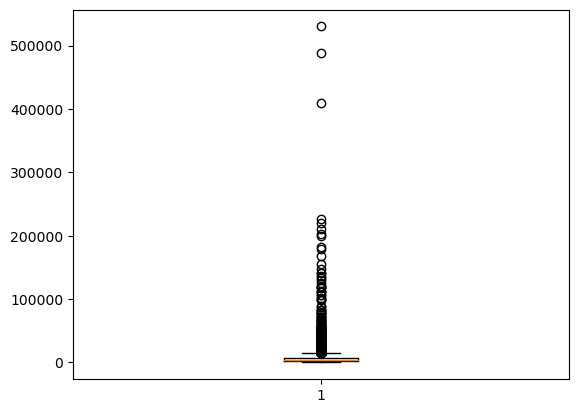

In [95]:
order_completed.head()
plt.boxplot(order_completed.order_sum)

Очень большое количество выбросов, при этом есть заказы > 100 т.р., что совсем не характерно для приложения доставки продуктов. Возможно также работа тестировщиков или бобтов. Это подтверждается тем, что средний чек (с учётом выбросов) ~6 т.р. Удаляю выбросы

In [101]:
temp=order_completed[ order_completed.order_sum>=order_completed.order_sum.quantile(.99)]
order_completed=order_completed[~order_completed.order_sum.isin(temp.order_sum)]
order_completed.describe()

,order_sum
count,16483.000000
mean,5587.596096
std,4903.485252
min,3.382452
25%,2257.181064
50%,4064.028029
75%,7252.150818
max,36612.583206


Отмечаю, что среднее не сильно сдвинулось, однако дисперсия упала в 2 раза

{'whiskers': [<matplotlib.lines.Line2D at 0x1a955587700>,
 'caps': [<matplotlib.lines.Line2D at 0x1a955587d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a955587430>],
 'medians': [<matplotlib.lines.Line2D at 0x1a955554d60>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a955555000>],
 'means': []}

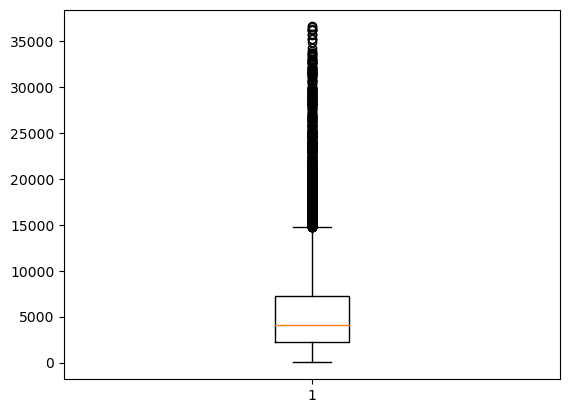

In [102]:
plt.boxplot(order_completed.order_sum)

#### DataFrame main - после лендинга идёт главная страница. 

По условиям эксперимента, необходимо, чтобы пользоватеь зашёл с лендинга на главную. Нужно посчитать разницу по времени посещения и она должна быть положительна. Остальное - не подходит

In [121]:
main_viewed.head()

,timestamp,anonymous_id,retailer_id
0,2020-11-29 08:54:57.64 UTC,00000782-154a-4159-ab12-6c34b658e375,1
1,2020-11-29 08:22:54.554 UTC,00000782-154a-4159-ab12-6c34b658e375,1
2,2020-11-30 10:56:52.877 UTC,00000782-154a-4159-ab12-6c34b658e375,1
3,2020-11-29 08:22:24.663 UTC,00000782-154a-4159-ab12-6c34b658e375,1
4,2020-11-29 09:07:11.648 UTC,00000782-154a-4159-ab12-6c34b658e375,1


### Расчёт показателей эксперимента

Расчёт количества посетителей лендинга по дням

In [116]:
import seaborn as sns
hit_land=landing_viewed.merge(ab_test_hit, on = 'anonymous_id')
temp=hit_land.groupby(['c_date','group'])['timestamp'].count().reset_index()

,c_date,group,timestamp
0,2020-11-26,address_first,1945
1,2020-11-26,default,15349
2,2020-11-27,address_first,1848
3,2020-11-27,default,15207
4,2020-11-28,address_first,2078
5,2020-11-28,default,15870
6,2020-11-29,address_first,1786
7,2020-11-29,default,13646
8,2020-11-30,address_first,1666
9,2020-11-30,default,13373


<Axes: xlabel='timestamp', ylabel='c_date'>

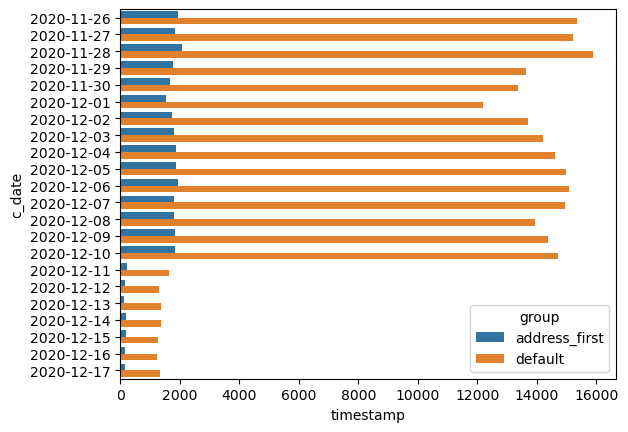

In [118]:

sns.barplot(y="c_date", x="timestamp", hue="group", data=temp)